# Analysis of Leios simulations at tag `leios-2025w15`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## Varied TPS

In [2]:
tmp1 <- fread("tps/1/tx.csv.gz", stringsAsFactors=TRUE)
tmp10 <- fread("tps/10/tx.csv.gz", stringsAsFactors=TRUE)
txs <- rbind(
    cbind(TPS=1, tmp1),
    cbind(TPS=10, tmp10)
)
txs %>% summary

      TPS               Tx        Generated [s]       Size [B]      
 Min.   : 1.000   Min.   :    0   Min.   :   0.0   Min.   :    6.0  
 1st Qu.:10.000   1st Qu.: 6718   1st Qu.: 899.7   1st Qu.:  434.0  
 Median :10.000   Median :17234   Median :1807.8   Median :  935.5  
 Mean   : 9.187   Mean   :17577   Mean   :1804.6   Mean   : 1701.7  
 3rd Qu.:10.000   3rd Qu.:27751   3rd Qu.:2708.8   3rd Qu.: 1992.0  
 Max.   :10.000   Max.   :38267   Max.   :3599.9   Max.   :16384.0  
                                                                    
 IB inclusions  Time to IB [s]   EB references    Time to EB reference [s]
 Min.   :0.00   Min.   : 0.132   Min.   : 0.000   Min.   : 21.11          
 1st Qu.:2.00   1st Qu.: 1.211   1st Qu.: 1.000   1st Qu.: 24.92          
 Median :2.00   Median : 1.734   Median : 3.000   Median : 27.50          
 Mean   :2.37   Mean   : 1.961   Mean   : 3.716   Mean   : 27.60          
 3rd Qu.:3.00   3rd Qu.: 2.426   3rd Qu.: 6.000   3rd Qu.: 30.06         

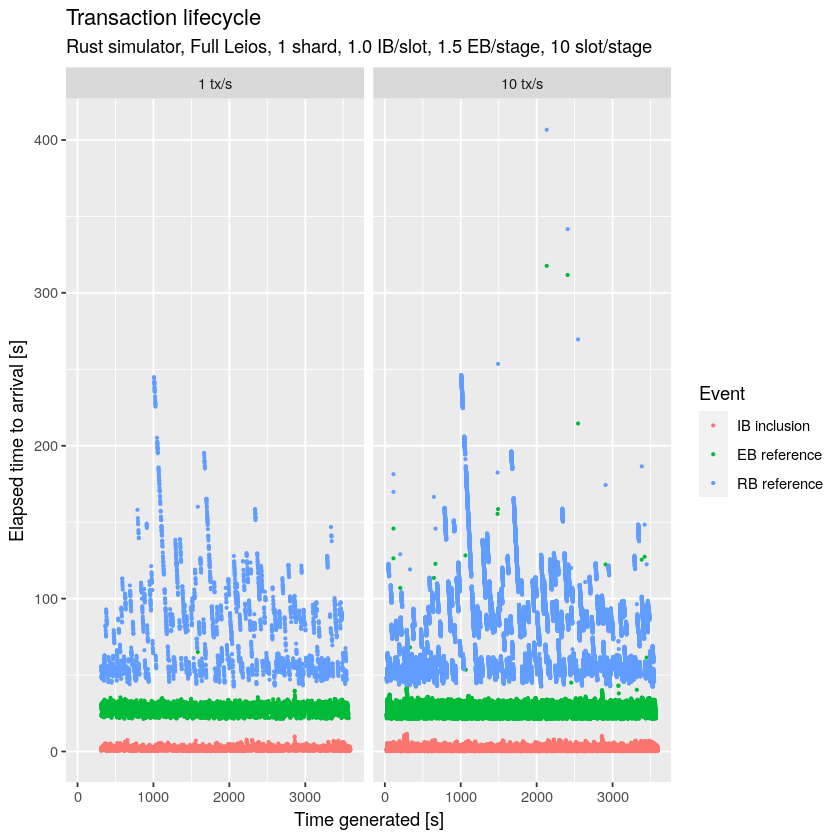

In [3]:
ggplot(
    melt(
        txs[is.na(`Time to Praos inclusion [s]`), .(
            `TPS`=factor(paste(`TPS`, "tx/s")),
            `Tx`,
            `Time generated [s]`=`Generated [s]`,
            `IB inclusion`=`Time to IB [s]`, 
            `EB reference`=`Time to EB reference [s]`, 
            `RB reference`=`Time to RB reference [s]`
        )],
        id.vars=c("TPS", "Tx", "Time generated [s]"),
        variable.name="Event",
        value.name="Elapsed time to arrival [s]"
    )[!is.na(`Elapsed time to arrival [s]`)],
    aes(x=`Time generated [s]`, y=`Elapsed time to arrival [s]`, color=`Event`)
) + geom_point(size=0.5) +
    facet_grid(. ~ `TPS`) +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [4]:
ggsave("plots/lifecycle-timeseries.png", units="in", dpi=150, width=9.50, height=5.25)

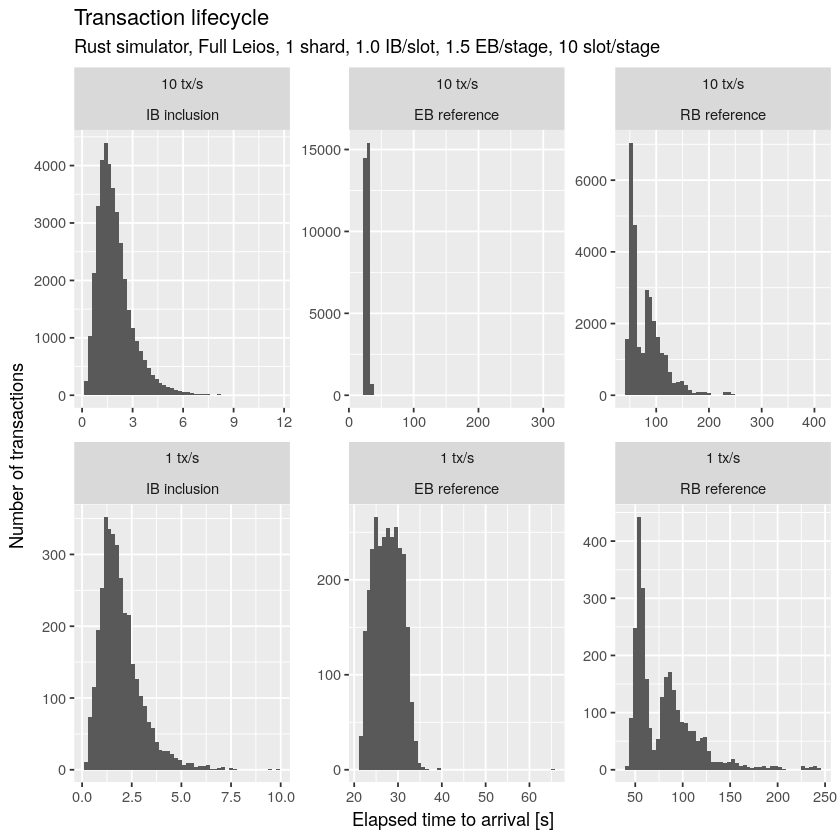

In [5]:
ggplot(
    melt(
        txs[is.na(`Time to Praos inclusion [s]`), .(
            `TPS`=factor(paste(`TPS`, "tx/s"), levels=c("10 tx/s", "1 tx/s")),
            `Tx`,
            `Time generated [s]`=`Generated [s]`,
            `IB inclusion`=`Time to IB [s]`, 
            `EB reference`=`Time to EB reference [s]`, 
            `RB reference`=`Time to RB reference [s]`
        )],
        id.vars=c("TPS", "Tx", "Time generated [s]"),
        variable.name="Event",
        value.name="Elapsed time to arrival [s]"
    )[`Event` != "RB inclusion" & !is.na(`Elapsed time to arrival [s]`)],
    aes(x=`Elapsed time to arrival [s]`)
) + geom_histogram(bins=50) +
    ylab("Number of transactions") +
    facet_wrap(`TPS` ~ `Event`, scales="free") +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [6]:
ggsave("plots/lifecycle-histogram.png", units="in", dpi=150, width=9.50, height=5.25)

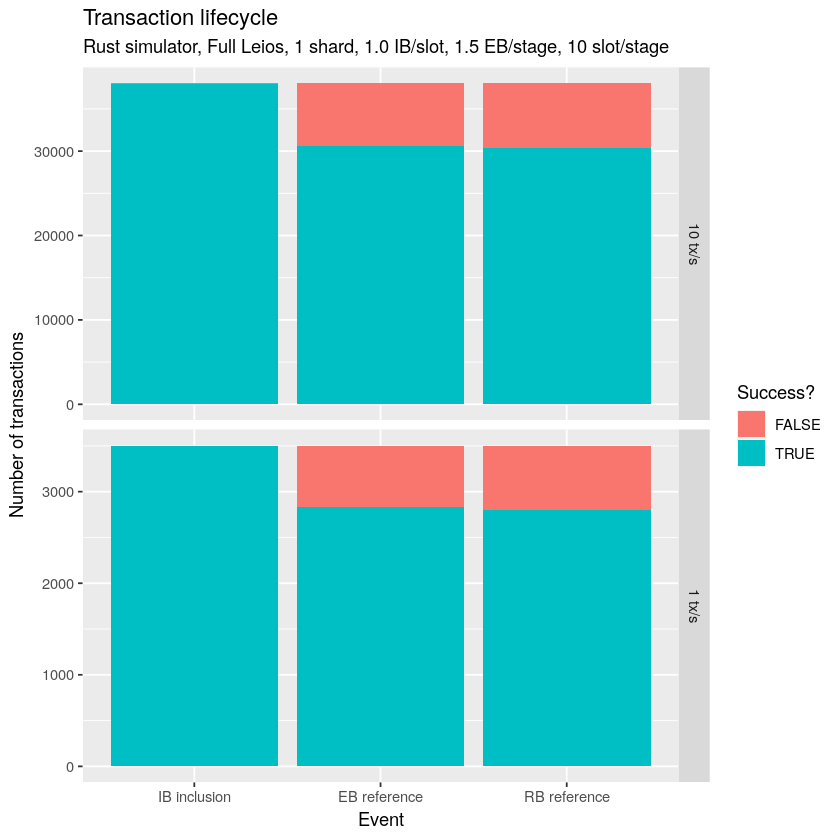

In [7]:
ggplot(
    melt(
        txs[is.na(`Time to Praos inclusion [s]`), .(
            `TPS`=factor(paste(`TPS`, "tx/s"), levels=c("10 tx/s", "1 tx/s")),
            `Tx`,
            `Time generated [s]`=`Generated [s]`,
            `IB inclusion`=`Time to IB [s]`, 
            `EB reference`=`Time to EB reference [s]`, 
            `RB reference`=`Time to RB reference [s]`
        )],
        id.vars=c("TPS", "Tx", "Time generated [s]"),
        variable.name="Event",
        value.name="Elapsed time to arrival [s]"
    )[, .(`TPS`, `Event`, `Success?`=!is.na(`Elapsed time to arrival [s]`))],
    aes(x=`Event`, fill=`Success?`)
) + geom_bar() +
    ylab("Number of transactions") +
    facet_grid(`TPS` ~ ., scales="free_y") +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [8]:
ggsave("plots/lifecycle-success.png", units="in", dpi=150, width=9.50, height=5.25)

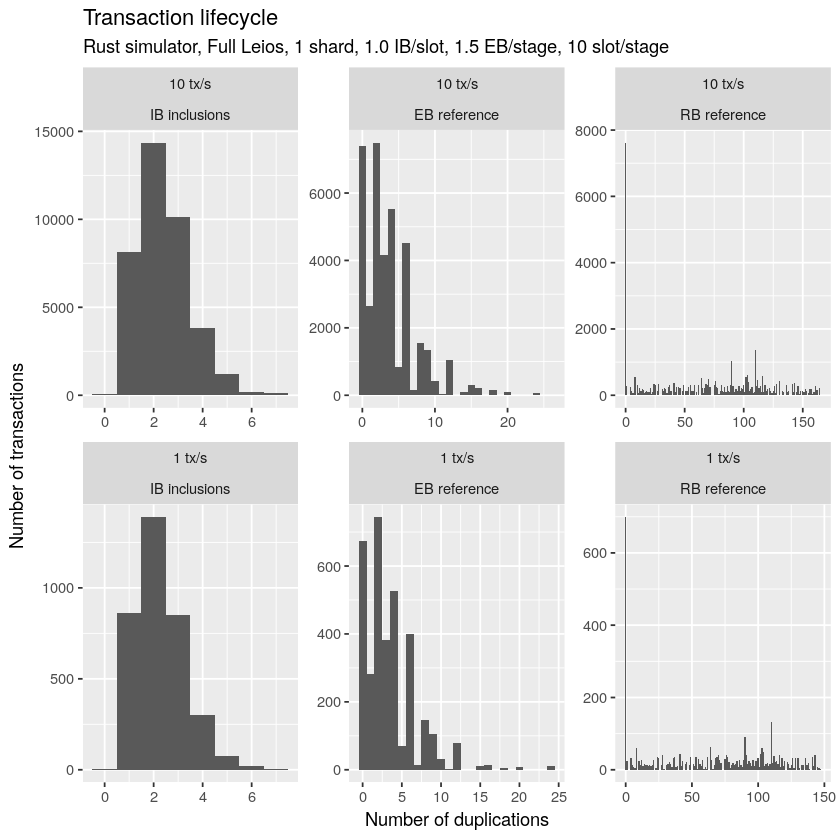

In [9]:
ggplot(
    melt(
        txs[`Praos inclusions` == 0, .(
            `TPS`=factor(paste(`TPS`, "tx/s"), levels=c("10 tx/s", "1 tx/s")),
            `Tx`,
            `IB inclusions`=`IB inclusions`, 
            `EB reference`=`EB references`, 
            `RB reference`=`RB references`
        )],
        id.vars=c("TPS", "Tx"),
        variable.name="Event",
        value.name="Number of duplications"
    ),
    aes(x=`Number of duplications`)
) + geom_histogram(binwidth=1) +
    ylab("Number of transactions") +
    facet_wrap(`TPS` ~ `Event`, scales="free") +
    ggtitle(
        "Transaction lifecycle",
        subtitle="Rust simulator, Full Leios, 1 shard, 1.0 IB/slot, 1.5 EB/stage, 10 slot/stage"
    )

In [10]:
ggsave("plots/lifecycle-duplication.png", units="in", dpi=150, width=9.50, height=5.25)